In [2]:
import taxopy
import os
import sklearn.datasets
import pandas as pd
import numpy as np
import umap
import umap.plot
import matplotlib.pyplot as plt


tax_path = '../../data/taxonomy/'

os.makedirs(tax_path, exist_ok=True)

taxdb = taxopy.TaxDb(taxdb_dir=tax_path, keep_files=True)

taxon = taxopy.Taxon(taxid=9606, taxdb=taxdb)
print(taxon.rank_name_dictionary['family'])

/home/alex/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alex/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/home/alex/.local/lib/python3.10/site-packages/numba/np/ufunc/dufunc.py:346: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/alex/.local/lib/python3.10/site-packag

Hominidae


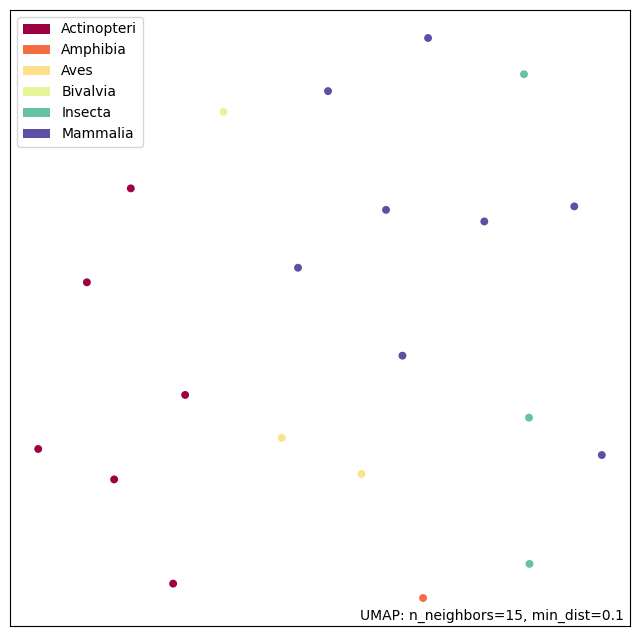

In [3]:
data, labels, id_to_name = np.load('../../data/processed_data/genome_embeddings.npz').values()

genome_lookup_table = pd.read_csv('../../data/raw_proteomes/ncbi_dataset/data/data_summary.tsv', sep='\t')
id_to_taxid = dict(zip(genome_lookup_table['Assembly Accession'], genome_lookup_table['Taxonomy id']))

def lookup_taxid(assembly_id, lookup_level='family'):
    taxid = id_to_taxid[assembly_id]
    taxon = taxopy.Taxon(taxid=taxid, taxdb=taxdb)
    return taxon.rank_name_dictionary[lookup_level]


mapper = umap.UMAP().fit(data)
umap.plot.points(mapper, labels=np.array([lookup_taxid(x, 'class') for x in labels]))

plt.show()

In [34]:
taxon = taxopy.Taxon(taxid=9606, taxdb=taxdb)
print(taxon.rank_name_dictionary)

OrderedDict({'species': 'Homo sapiens', 'genus': 'Homo', 'subfamily': 'Homininae', 'family': 'Hominidae', 'superfamily': 'Hominoidea', 'parvorder': 'Catarrhini', 'infraorder': 'Simiiformes', 'suborder': 'Haplorrhini', 'order': 'Primates', 'superorder': 'Euarchontoglires', 'clade': 'Opisthokonta', 'class': 'Mammalia', 'superclass': 'Sarcopterygii', 'subphylum': 'Craniata', 'phylum': 'Chordata', 'kingdom': 'Metazoa', 'domain': 'Eukaryota', 'cellular root': 'cellular organisms'})


In [15]:
from sklearn.neighbors import NearestNeighbors

def setup_nn_search(data, labels):
    id_to_index = {id_: idx for idx, id_ in enumerate(labels)}
    nn_model = NearestNeighbors(n_neighbors=10, algorithm='auto').fit(data)
    return nn_model, id_to_index

nn_model, id_to_index = setup_nn_search(data, id_to_name)

def get_nearest_neighbors(assembly_id, n=5):
    idx = id_to_index[assembly_id]
    distances, indices = nn_model.kneighbors([data[idx]], n_neighbors=n+1)
    neighbors = [(id_to_name[i], distances[0][j]) for j, i in enumerate(indices[0]) if i != idx]
    return neighbors

def get_nearest_neighbors_vec(vector, n=5):
    distances, indices = nn_model.kneighbors([vector], n_neighbors=n)
    neighbors = [(id_to_name[i], distances[0][j]) for j, i in enumerate(indices[0])]
    return neighbors

print(get_nearest_neighbors('pig', n=5))

[('olive baboon', 0.290523886680603), ('gray mouse lemur', 0.3141386806964874), ('goat', 0.3264353275299072), ('Ryukyu mouse', 0.3272881805896759), ('sheep', 0.35259076952934265)]


In [24]:
def get_vector(name):
    idx = id_to_index[name]
    return data[idx]

print(get_nearest_neighbors_vec((get_vector('olive baboon') - get_vector('chimpanzee') + get_vector('sheep')), n=5))

[('sheep', 0.3706660270690918), ('olive baboon', 0.37917613983154297), ('shrew mouse', 0.3917390704154968), ('goat', 0.42721402645111084), ('pig', 0.5095683932304382)]


In [18]:
print(id_to_name)

['chimpanzee' 'zebrafish' 'red flour beetle' 'pig' 'gray mouse lemur'
 'olive baboon' 'Mexican tetra' 'northern pike' 'Japanese quail'
 'African clawed frog' 'goat' 'eastern oyster' 'helmeted guineafowl'
 'rainbow trout' 'yellow fever mosquito' 'Japanese medaka' 'nan' 'sheep'
 'southern platyfish' 'Ryukyu mouse' 'shrew mouse']
